In [2]:
# ## Simple XGBoost Model with Evaluation Metrics (Using "item_id", "store_id", and "date")

# ### Step 1: Import Required Libraries
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import os

# Set the working directory
os.chdir("/Users/alexanderschou/Desktop/Projects/adv_mla_2024/AT2_experimentation/data/processed")

# ### Step 2: Load the Data
sales_train_processed = pd.read_csv('sales_train_processed.csv')

# ### Step 3: Filter Relevant Columns
# Only use "item_id", "store_id", and "date" columns as features
X = sales_train_processed[['item_id', 'store_id', 'date']]
y = sales_train_processed['revenue']

# Specify categorical columns
categorical_columns = ['item_id', 'store_id']

# ### Step 4: Preprocessing Pipeline
# Define preprocessing for categorical columns (Imputation + OneHotEncoding)
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine categorical preprocessing into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_preprocessor, categorical_columns)
    ])

# ### Step 5: Define XGBoost Pipeline
# Pipeline includes preprocessing followed by XGBoost regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# ### Step 6: Train-Test Split
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ### Step 7: Model Training
pipeline.fit(X_train, y_train)

# ### Step 8: Model Evaluation
# Predict on validation set
y_pred = pipeline.predict(X_val)

# ### Step 9: Compute Evaluation Metrics
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R-squared (R2) Score
r2 = r2_score(y_val, y_pred)
print(f"R-squared (R2): {r2:.2f}")

# ### Step 10: Save the Model
# Refit on the entire dataset and save the trained model
#pipeline.fit(X, y)
#os.chdir("/Users/alexanderschou/Desktop/Projects/adv_mla_2024/AT2_experimentation/models/predictive")
#import joblib
#joblib.dump(pipeline, 'xgboost_model_new.joblib')


/var/folders/mh/j3zy8xqx2v32dk0tv4nx5x8m0000gn/T/ipykernel_771/3615670521.py:19: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_train_processed = pd.read_csv('sales_train_processed.csv')


Mean Absolute Error (MAE): 3.84
Root Mean Squared Error (RMSE): 7.66
R-squared (R2): 0.30


In [ ]:
pip install hyperopt

In [10]:
# Import Required Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Set the working directory
#os.chdir("/Users/alexanderschou/Desktop/Projects/adv_mla_2024/AT2_experimentation/data/processed")

# Load the Data
#sales_train_processed = pd.read_csv('sales_train_processed.csv')

# Filter Relevant Columns
#X = sales_train_processed[['item_id', 'store_id', 'date']]
#y = sales_train_processed['revenue']

# Use a smaller subset of data for tuning (e.g., 20% of the original data)
X_tune, _, y_tune, _ = train_test_split(X, y, test_size=0.9, random_state=42)

# Specify categorical columns
categorical_columns = ['item_id', 'store_id']

# Define Preprocessing Pipeline
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine categorical preprocessing into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_preprocessor, categorical_columns)
    ])

# Define the objective function for Hyperopt
def objective(params):
    # Set random state for reproducibility
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **params
    )
    
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Split the tuning data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_tune, y_tune, test_size=0.2, random_state=42)
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = pipeline.predict(X_val)
    
    # Compute evaluation metrics
    mae = mean_absolute_error(y_val, y_pred)
    
    # Return the MAE for Hyperopt to minimize
    return {'loss': mae, 'status': STATUS_OK}

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300]),
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

# Use Hyperopt to find the best hyperparameters
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,  # Number of evaluations to perform
    trials=trials
)

print("Best Hyperparameters:", best)

# After finding the best parameters, convert choices back to actual values
best['n_estimators'] = [100, 200, 300][best['n_estimators']]
best['max_depth'] = [3, 4, 5, 6, 7][best['max_depth']]

# Train the final model with the best hyperparameters on the entire dataset
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best
)

# Create final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# Train on the full dataset
final_pipeline.fit(X, y)

# Evaluate the final model
y_pred_final = final_pipeline.predict(X)
final_mae = mean_absolute_error(y, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y, y_pred_final))
final_r2 = r2_score(y, y_pred_final)

print(f"Final Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {final_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {final_rmse:.2f}")
print(f"R-squared (R2): {final_r2:.2f}")

# Save the final model
#import joblib
#os.chdir("/Users/alexanderschou/Desktop/Projects/adv_mla_2024/AT2_experimentation/models/predictive")
#joblib.dump(final_pipeline, 'xgboost_model_optimized.joblib')


100%|█████████| 20/20 [09:27<00:00, 28.38s/trial, best loss: 3.7192503592989095]
Best Hyperparameters: {'colsample_bytree': 0.7304394507156755, 'learning_rate': 0.2491077580119362, 'max_depth': 4, 'n_estimators': 1, 'subsample': 0.6634318132439291}
Final Model Evaluation Metrics:
Mean Absolute Error (MAE): 3.71
Root Mean Squared Error (RMSE): 7.47
R-squared (R2): 0.34


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_val)

# ### Step 9: Compute Evaluation Metrics
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R-squared (R2) Score
r2 = r2_score(y_val, y_pred)
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 3.71
Root Mean Squared Error (RMSE): 7.50
R-squared (R2): 0.33


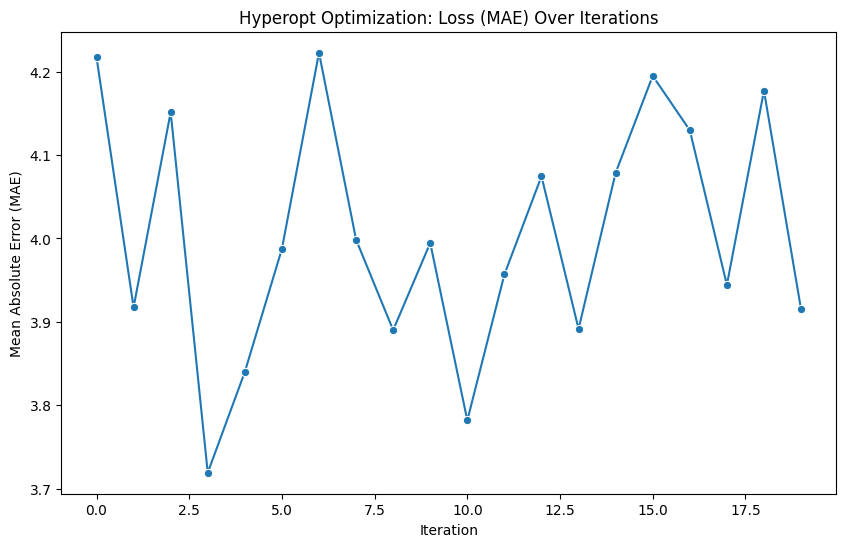

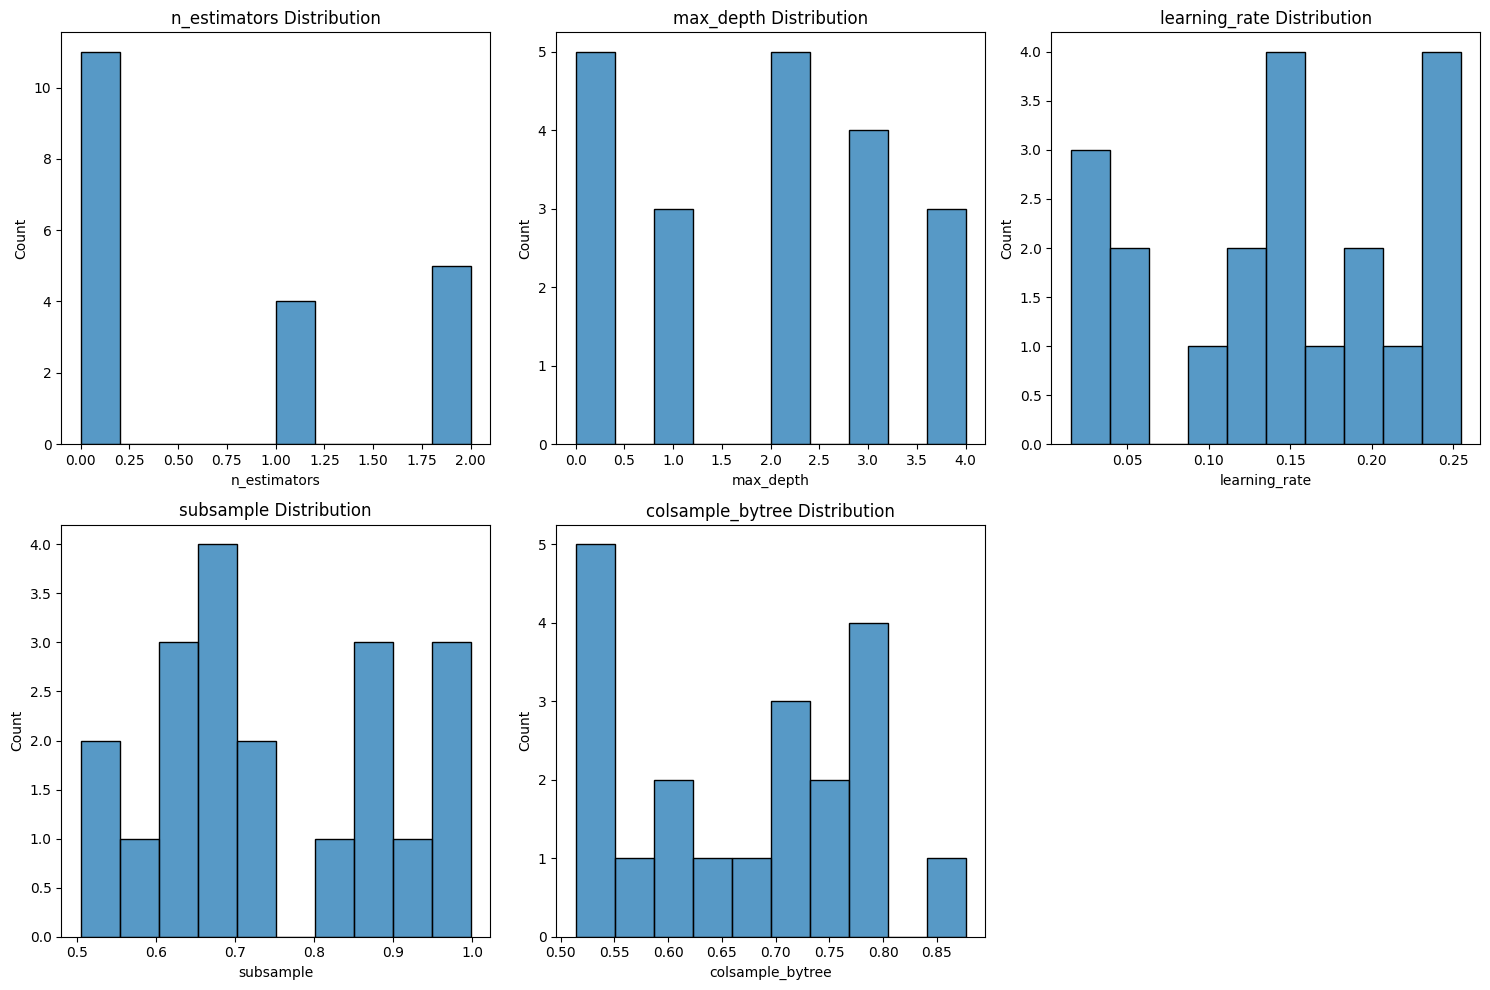

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot the loss (MAE) over iterations
def plot_hyperopt_results(trials):
    results = pd.DataFrame({
        'iteration': range(len(trials.results)),
        'loss': [trial['result']['loss'] for trial in trials.trials]
    })
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results, x='iteration', y='loss', marker='o')
    plt.title('Hyperopt Optimization: Loss (MAE) Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.show()

# Plot the distributions of hyperparameters tried by Hyperopt
def plot_hyperparameter_distributions(trials):
    # Extract the hyperparameters from the trials
    params = pd.DataFrame([{
        'n_estimators': trial['misc']['vals'].get('n_estimators', [None])[0],
        'max_depth': trial['misc']['vals'].get('max_depth', [None])[0],
        'learning_rate': trial['misc']['vals'].get('learning_rate', [None])[0],
        'subsample': trial['misc']['vals'].get('subsample', [None])[0],
        'colsample_bytree': trial['misc']['vals'].get('colsample_bytree', [None])[0]
    } for trial in trials.trials])

    plt.figure(figsize=(15, 10))
    
    # Plot n_estimators
    plt.subplot(2, 3, 1)
    sns.histplot(params['n_estimators'], bins=10)
    plt.title('n_estimators Distribution')
    
    # Plot max_depth
    plt.subplot(2, 3, 2)
    sns.histplot(params['max_depth'], bins=10)
    plt.title('max_depth Distribution')
    
    # Plot learning_rate
    plt.subplot(2, 3, 3)
    sns.histplot(params['learning_rate'], bins=10)
    plt.title('learning_rate Distribution')
    
    # Plot subsample
    plt.subplot(2, 3, 4)
    sns.histplot(params['subsample'], bins=10)
    plt.title('subsample Distribution')
    
    # Plot colsample_bytree
    plt.subplot(2, 3, 5)
    sns.histplot(params['colsample_bytree'], bins=10)
    plt.title('colsample_bytree Distribution')
    
    plt.tight_layout()
    plt.show()

# After running Hyperopt, generate the plots
plot_hyperopt_results(trials)
plot_hyperparameter_distributions(trials)


In [14]:
import joblib
os.chdir("/Users/alexanderschou/Desktop/Projects/adv_mla_2024/AT2_experimentation/models/predictive")
joblib.dump(final_pipeline, 'xgboost_model_optimized.joblib')


['xgboost_model_optimized.joblib']